[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/LNHunter/blob/master/binary_classification.ipynb)

# Binary classification

## Data loading and preparation

In [1]:
import numpy as np
import pandas as pd

import os
import pickle

data_dir  = "./data"
data_file = "db_mediastinalbulky_v2-reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               119 non-null    float64
 1   lymphoma_type                    119 non-null    float64
 2   age                              111 non-null    float64
 3   SUVmin (SUV)                     111 non-null    float64
 4   SUVmean (SUV)                    111 non-null    float64
 5   MTV (# vx)                       111 non-null    float64
 6   SMTV (mL/Kg) TOT                 111 non-null    float64
 7   CONVENTIONAL_SUVbwmin            115 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       115 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       110 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  113 non-null    float64
 11  GLCM_Correlation                 113 non-null    float64
 12  GLRLM_SRE             

### Aggressive data cleaning 

In [2]:
data . dropna ( inplace = True )
data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               101 non-null    float64
 1   lymphoma_type                    101 non-null    float64
 2   age                              101 non-null    float64
 3   SUVmin (SUV)                     101 non-null    float64
 4   SUVmean (SUV)                    101 non-null    float64
 5   MTV (# vx)                       101 non-null    float64
 6   SMTV (mL/Kg) TOT                 101 non-null    float64
 7   CONVENTIONAL_SUVbwmin            101 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       101 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       101 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  101 non-null    float64
 11  GLCM_Correlation                 101 non-null    float64
 12  GLRLM_SRE             

### Splitting into train-set and test-set

In [3]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

binary_class = (data[y_cols] != 2)   # exclude GZ class

X = data[binary_class][X_cols] . to_numpy()
y = data[binary_class][y_cols] . to_numpy() . flatten()

ratio = len(y[y == 3]) / len(y[y == 1])
print ( "Label ratio on data-set : {:.1f}%" . format (100 * ratio) )

Label ratio on data-set : 41.5%


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size = 0.2, random_state = 42 )

ratio_train = len(y_train[y_train == 3]) / len(y_train[y_train == 1])
print ( "Label ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

ratio_test = len(y_test[y_test == 3]) / len(y_test[y_test == 1])
print ( "Label ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

Label ratio on train-set : 46.0%
Label ratio on test-set  : 26.7%


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.2, random_state = 42 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train = X[idx_train] , y[idx_train]
  X_test  , y_test  = X[idx_test]  , y[idx_test]

ratio_train = len(y_train[y_train == 3]) / len(y_train[y_train == 1])
print ( "Label ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

ratio_test = len(y_test[y_test == 3]) / len(y_test[y_test == 1])
print ( "Label ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

Label ratio on train-set : 40.4%
Label ratio on test-set  : 46.2%


## Simple binary classification

In [6]:
import optuna
optuna.logging.set_verbosity ( optuna.logging.ERROR )   # silence Optuna during trials study

### Return a set of trials studied by Optuna
def optuna_study (
                   model_name  : str ,
                   storage_dir : str ,
                   objective   : float ,
                   n_trials    : int = 10 ,
                   direction : str = "minimize"  , 
                   load_if_exists : bool = False ,
                 ):
  storage_path = "{}/{}.db" . format (storage_dir, model_name)
  storage_name = "sqlite:///{}" . format (storage_path)  

  if load_if_exists:
    pass
  elif not ( load_if_exists ) and os.path.isfile ( storage_path ):
    os.remove ( storage_path )

  study = optuna.create_study ( 
                                study_name = model_name ,
                                storage  = storage_name ,
                                load_if_exists = load_if_exists ,
                                direction = direction
                              )

  study . optimize ( objective, n_trials = n_trials )

  return study

### Dummy Classifier

In [7]:
from utils import DummyClassifier

clf_dummy = DummyClassifier()

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score ( clf_dummy, X_train, y_train, scoring = "accuracy", cv = 3 )

def display_score ( model_name: str, scores: list ):
  str_len = len ( model_name )
  print ( "+--" + "-" * str_len + "--+")
  print ( "|  {}  |" . format (model_name) )
  print ( "+--" + "-" * str_len + "--+")
  print ( "| Accuracy : {}" . format ( scores ) )
  print ( "| Mean : {:.1f}%" . format ( 100 * np.mean(scores) ) )
  print ( "| Std  : {:.1f}%" . format ( 100 * np.std (scores) ) )
  print ( "+--- - -")

display_score ( model_name = "Dummy Classifier", scores = scores )

+--------------------+
|  Dummy Classifier  |
+--------------------+
| Accuracy : [0.6        0.58333333 0.625     ]
| Mean : 60.3%
| Std  : 1.7%
+--- - -


+---->  Label HL   <----+
|   Precision : 66.0%   |
|   Recall    : 63.5%   |
+---->  Label PML  <----+
|   Precision : 17.4%   |
|   Recall    : 19.0%   |
+-----------------------+


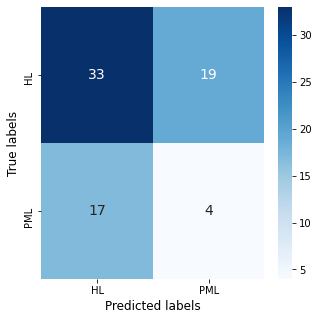

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import confusion_matrix

y_train_pred = cross_val_predict ( clf_dummy, X_train, y_train, cv = 3 )


def precision_recall_scores ( y_true, y_pred, verbose = False, labels = None, show_conf_matrix = False ):
  if labels is not None:
    if len(labels) != len(np.unique(y_true)):
      raise ValueError ( "Labels list length doesn't match with the true number of classes." )
  else:
    labels = np.arange ( len(np.unique(y_true)) )

  conf_matrix = confusion_matrix ( y_train, y_train_pred )
  precision = np.zeros ( len(conf_matrix) )
  recall    = np.zeros ( len(conf_matrix) )

  for i in range ( len(conf_matrix) ):
    precision[i] = conf_matrix[i,i] / np.sum ( conf_matrix[:,i] )
    recall[i]    = conf_matrix[i,i] / np.sum ( conf_matrix[i,:] )
    if verbose:
      print ( "+---->  Label {:3}  <----+" . format (labels[i]) )
      print ( "|   Precision : {:.1f}%   |" . format (100 * precision[i]) )
      print ( "|   Recall    : {:.1f}%   |" . format (100 * recall[i])    )
  if verbose: print ( "+-----------------------+" )

  if show_conf_matrix:
    plt.figure ( figsize = (5,5) )
    conf_matrix = pd.DataFrame (conf_matrix, index = labels, columns = labels )
    sns.heatmap ( conf_matrix, annot = True, annot_kws = { "size" : 14 }, cmap = "Blues" )
    plt.xlabel ( "Predicted labels", fontsize = 12 )
    plt.ylabel ( "True labels", fontsize = 12)
    plt.show()

  return precision, recall


_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )


### Random Forest

+----------------------------+
|  Random Forest Classifier  |
+----------------------------+
| Accuracy : [0.88       0.66666667 0.875     ]
| Mean : 80.7%
| Std  : 9.9%
+--- - -
+---->  Label HL   <----+
|   Precision : 84.9%   |
|   Recall    : 86.5%   |
+---->  Label PML  <----+
|   Precision : 65.0%   |
|   Recall    : 61.9%   |
+-----------------------+


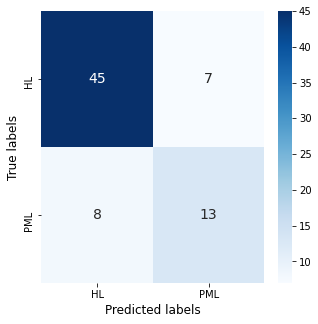

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier (
                                      n_estimators = 100 ,
                                      criterion = "gini" ,
                                      max_features = "sqrt" ,
                                      max_leaf_nodes = 10 ,
                                      max_depth = 5 ,
                                    )

scores = cross_val_score ( clf_forest, X_train, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_forest, X_train, y_train, cv = 3 )

display_score ( model_name = "Random Forest Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

#### Automatic hyperparameters tuning

In [11]:
def obj_forest (trial):
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["gini", "entropy"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )

  model = RandomForestClassifier ( 
                                   n_estimators = n_estims ,
                                   criterion = criterion   ,
                                   max_features = max_feats  ,
                                   max_leaf_nodes = max_leaf ,
                                   max_depth = max_depth ,
                                 )
  
  y_pred  = cross_val_predict ( model, X_train, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ 1 - ratio_train, ratio_train ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_forest = optuna_study (
                              model_name  = "clf_forest"  ,
                              storage_dir = "./storage" ,
                              objective = obj_forest ,
                              n_trials  = 50 ,
                              direction = "maximize" ,
                              load_if_exists = False ,
                            )

In [12]:
df = study_forest . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_criterion,params_max_depth,params_max_feats,params_max_leaf,params_n_estims,value
0,gini,8,log2,14,223,0.71853
37,gini,8,log2,10,340,0.71853
27,entropy,7,None,18,129,0.71853
28,entropy,9,None,14,63,0.71853
29,entropy,9,None,14,71,0.71853


+----------------------------+
|  Random Forest Classifier  |
+----------------------------+
| Accuracy : [0.84       0.70833333 0.91666667]
| Mean : 82.2%
| Std  : 8.6%
+--- - -
+---->  Label HL   <----+
|   Precision : 83.3%   |
|   Recall    : 86.5%   |
+---->  Label PML  <----+
|   Precision : 63.2%   |
|   Recall    : 57.1%   |
+-----------------------+


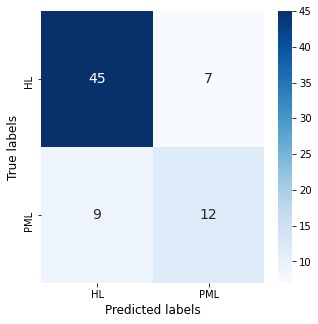

In [13]:
best_params = study_forest . best_params

clf_forest = RandomForestClassifier (
                                      n_estimators = best_params["n_estims"] ,
                                      criterion = best_params["criterion"]   ,
                                      max_features = best_params["max_feats"]  ,
                                      max_leaf_nodes = best_params["max_leaf"] ,
                                      max_depth = best_params["max_depth"] ,
                                    )

scores = cross_val_score ( clf_forest, X_train, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_forest, X_train, y_train, cv = 3 )

display_score ( model_name = "Random Forest Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

### Gradient Boosted Decision Trees

+-------------------+
|  GBDT Classifier  |
+-------------------+
| Accuracy : [0.84       0.66666667 0.79166667]
| Mean : 76.6%
| Std  : 7.3%
+--- - -
+---->  Label HL   <----+
|   Precision : 83.0%   |
|   Recall    : 84.6%   |
+---->  Label PML  <----+
|   Precision : 60.0%   |
|   Recall    : 57.1%   |
+-----------------------+


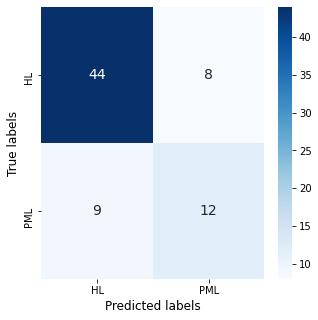

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbdt = GradientBoostingClassifier (
                                        loss = "deviance" ,
                                        learning_rate = 0.3 ,
                                        n_estimators  = 100 ,
                                        criterion = "friedman_mse" ,
                                        max_leaf_nodes = 10 ,
                                        max_depth = 5       ,
                                      )

scores = cross_val_score ( clf_gbdt, X_train, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3 )

display_score ( model_name = "GBDT Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

#### Automatic hyperparameters tuning

In [16]:
def obj_gbdt (trial):
  loss = trial . suggest_categorical ( "loss", ["deviance", "exponential"] )
  lr   = trial . suggest_float ( "lr", 0.05, 0.95, log = True )
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["friedman_mse", "mse"] ) 
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )

  model = GradientBoostingClassifier ( 
                                       loss = loss ,
                                       learning_rate =  lr , 
                                       n_estimators  =  n_estims , 
                                       criterion  =  criterion   ,
                                       max_leaf_nodes = max_leaf ,
                                       max_depth = max_depth ,
                                     )
  
  #scores = cross_val_score ( model, X_train, y_train, scoring = "accuracy", cv = 3 )
  y_pred  = cross_val_predict ( model, X_train, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ 1 - ratio_train, ratio_train ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_gbdt = optuna_study (
                          model_name  = "clf_gbdt"  ,
                          storage_dir = "./storage" ,
                          objective = obj_gbdt ,
                          n_trials  = 50 ,
                          direction = "maximize" ,
                          load_if_exists = False ,
                        )

In [17]:
df = study_gbdt . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_criterion,params_loss,params_lr,params_max_depth,params_max_leaf,params_n_estims,value
0,friedman_mse,exponential,0.170911,2,6,497,0.682375
37,mse,exponential,0.145962,9,5,73,0.682375
27,friedman_mse,deviance,0.196717,4,3,217,0.682375
28,friedman_mse,exponential,0.113401,1,5,445,0.682375
29,friedman_mse,exponential,0.073108,2,7,257,0.682375


+-------------------+
|  GBDT Classifier  |
+-------------------+
| Accuracy : [0.84       0.70833333 0.83333333]
| Mean : 79.4%
| Std  : 6.1%
+--- - -
+---->  Label HL   <----+
|   Precision : 84.9%   |
|   Recall    : 86.5%   |
+---->  Label PML  <----+
|   Precision : 65.0%   |
|   Recall    : 61.9%   |
+-----------------------+


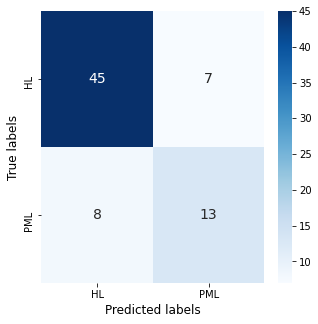

In [18]:
best_params = study_gbdt . best_params

clf_gbdt = GradientBoostingClassifier (
                                        loss = best_params["loss"] ,
                                        learning_rate = best_params["lr"] ,
                                        n_estimators  = best_params["n_estims"]  ,
                                        criterion  =  best_params["criterion"]   ,
                                        max_leaf_nodes = best_params["max_leaf"] ,
                                        max_depth = best_params["max_depth"] ,
                                      )

scores = cross_val_score ( clf_gbdt, X_train, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3 )

display_score ( model_name = "GBDT Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

### Model evaluation

In [19]:
from sklearn.metrics import accuracy_score

#final_predictions = final_model . predict ( X_test )
#final_scores = accuracy_score ( y_test, final_predictions )

#display_score ( model_name = "Best Classifier", scores = final_scores )

### Model export

In [20]:
model_dir = "./models"
#exp_model_file = "model_test.pkl"
#exp_model_path = os.path.join ( model_dir, exp_model_file )

#pickle . dump ( model, open ( exp_model_path, "wb" ) )